In [1]:
########################################################################
#
# Example of 3D Bragg ptycho reconstruction from simulated data
# (c) ESRF 2017-present
# Authors: Vincent Favre-Nicolin <favre@esrf.fr>
#
########################################################################

import timeit
import numpy as np
from pynx.ptycho.bragg import *
from pynx.ptycho.simulation import spiral_archimedes
from pynx.wavefront import Wavefront, ImshowRGBA, ImshowAbs
import matplotlib.pyplot as plt
from pynx.processing_unit import default_processing_unit as main_default_processing_unit

main_default_processing_unit.use_gpu()

gpyfft version: 0.7.0
Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                            Iris Pro [Apple]: 1536Mb [max alloc.: 384Mb],  22.15 Gflop/s
                  AMD Radeon R9 M370X Compute Engine [Apple]: 2048Mb [max alloc.: 512Mb],  69.26 Gflop/s
Using OpenCL GPU: AMD Radeon R9 M370X Compute Engine


True

In [2]:
# Experiment parameters
wavelength = 1.5e-10
nu = np.deg2rad(30)
delta = 0
pixel_size_detector = 55e-6
ny, nx = (160, 160)
npsi = 80
psi_step = np.deg2rad(0.01)
detector_distance = 1

# Spiralscan positions (will be rotated)
nb = 10
xs, ys = spiral_archimedes(200e-9, nb)
zs = np.zeros_like(xs)

# Use only one stack - if memory allows it !
default_processing_unit.cl_stack_size = nb

# detector parameters
detector = {'geometry': 'psic', 'delta': delta, 'nu': nu, 'pixel_size': pixel_size_detector,
            'distance': detector_distance, 'rotation_axis': 'phi', 'rotation_step': psi_step}

In [3]:
# Create empty data
data = BraggPtychoData(iobs=np.empty((nb, npsi, ny, nx), dtype=np.float32), positions=(xs, ys, zs), mask=None,
                       wavelength=wavelength, detector=detector)

In [4]:
# Import existing probe from 2D ptycho
d = np.load("/Users/favre/Analyse/201606id01-FZP/ResultsScan0013/latest.npz")
# d = np.load("/Users/vincent/Analyse/201606id01-FZP/ResultsScan0000/latest.npz")
pr = Wavefront(d=np.fft.fftshift(d['probe']), z=0, pixel_size=d['pixelsize'], wavelength=wavelength)
%matplotlib inline
#pr=ImshowRGBA()*pr

In [5]:
# Create main Bragg Ptycho object
p = BraggPtycho(probe=pr, data=data, support=None)
pxyz = p.voxel_size_object()
print("Object voxel size: %6.2fnm x %6.2fnm x %6.2fnm" % (pxyz[0] * 1e9, pxyz[1] * 1e9, pxyz[2] * 1e9))

Calculating probe on object grid
Initialised object with 98x208x196 voxels
Object voxel size:  21.49nm x  17.05nm x  17.65nm


/Users/favre/dev/py35-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


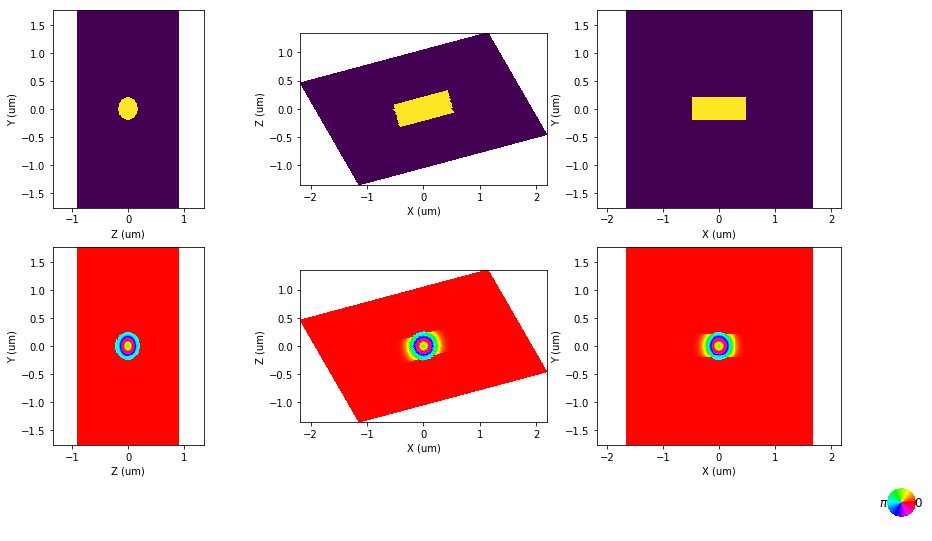

In [6]:
# Create nanowire
x, y, z = p.get_xyz(domain='object', rotation=('y', nu / 2))
obj0 = (abs(x) < 500e-9) * (np.sqrt(y ** 2 + z ** 2) < 200e-9)
if True:
    # Add some strain in the center
    obj1 = obj0 * np.exp(1j * 8 * np.exp(-(x ** 2 + y ** 2 + z ** 2) / 200e-9 ** 2))
    p.set_obj(obj1)
else:
    # A dislocation ? Twin domain ?
    pass
%matplotlib inline
p = ShowObj() * p

In [7]:
# Calculate the observed intensity and copy it to the observed ones
p = Calc2Obs() * FT() * ObjProbe2Psi() * p
# Apply a scale factor and use Poisson noise
p.data.iobs = np.random.poisson(p.data.iobs * 1e10 / p.data.iobs.sum())
# KLUDGE: we clear GPU data to make sure the new iobs will be used
p = FreePU() * p

Using OpenCL GPU: AMD Radeon R9 M370X Compute Engine
Moving observed data to OpenCL GPU


/Users/favre/dev/py35-env/lib/python3.5/site-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


Moving object, probe, mask, support to OpenCL GPU


In [8]:
# Set a support larger than the object 
# Note that if the support is too large in the incident beam direction, the resulting object is blurred
sup = (abs(x) < 800e-9) * (np.sqrt(y ** 2 + z ** 2) < 400e-9)
p.set_support(sup)

# Go back to the unstrained object as a starting point
p.set_obj(obj0)

Moving observed data to OpenCL GPU
Moving object, probe, mask, support to OpenCL GPU


/Users/favre/dev/py35-env/lib/python3.5/site-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


DM #  0 LLK=   415.58(p)  1638.29(g)   586.89(e), nb photons=6.183994e+09, dt/cycle=0.715s


/Users/favre/dev/py35-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


DM #  1 LLK=   423.93(p)   354.50(g)   535.73(e), nb photons=3.983109e+09, dt/cycle=0.664s
DM #  2 LLK=   350.33(p)   241.27(g)   451.57(e), nb photons=4.289058e+09, dt/cycle=0.652s
DM #  3 LLK=   243.26(p)   173.04(g)   317.84(e), nb photons=5.558217e+09, dt/cycle=0.653s
DM #  4 LLK=   164.93(p)   116.71(g)   215.97(e), nb photons=6.828700e+09, dt/cycle=0.650s
DM #  5 LLK=   108.91(p)    79.42(g)   145.34(e), nb photons=7.814430e+09, dt/cycle=0.657s
DM #  6 LLK=    69.71(p)    54.94(g)    96.91(e), nb photons=8.454106e+09, dt/cycle=0.656s
DM #  7 LLK=    40.09(p)    35.40(g)    58.62(e), nb photons=8.937794e+09, dt/cycle=0.654s
DM #  8 LLK=    19.49(p)    20.19(g)    30.67(e), nb photons=9.325264e+09, dt/cycle=0.652s
DM #  9 LLK=     7.92(p)     9.93(g)    13.60(e), nb photons=9.613158e+09, dt/cycle=0.649s
DM # 10 LLK=     3.39(p)     4.71(g)     6.15(e), nb photons=9.795289e+09, dt/cycle=0.653s
DM # 11 LLK=     2.10(p)     2.81(g)     3.83(e), nb photons=9.881866e+09, dt/cycle=0.640s

ML #  7 LLK=     0.52(p)     0.79(g)     1.32(e), nb photons=9.999987e+09, dt/cycle=1.152s
ML #  8 LLK=     0.52(p)     0.79(g)     1.32(e), nb photons=9.999830e+09, dt/cycle=1.157s
ML #  9 LLK=     0.51(p)     0.78(g)     1.31(e), nb photons=9.999913e+09, dt/cycle=1.155s
ML # 10 LLK=     0.51(p)     0.78(g)     1.31(e), nb photons=9.999950e+09, dt/cycle=1.161s
ML # 11 LLK=     0.51(p)     0.78(g)     1.31(e), nb photons=1.000007e+10, dt/cycle=1.156s
ML # 12 LLK=     0.51(p)     0.78(g)     1.31(e), nb photons=9.999986e+09, dt/cycle=1.155s
ML # 13 LLK=     0.51(p)     0.78(g)     1.31(e), nb photons=1.000012e+10, dt/cycle=1.155s
ML # 14 LLK=     0.50(p)     0.78(g)     1.31(e), nb photons=1.000020e+10, dt/cycle=1.154s
ML # 15 LLK=     0.50(p)     0.78(g)     1.31(e), nb photons=1.000025e+10, dt/cycle=1.152s
ML # 16 LLK=     0.50(p)     0.78(g)     1.31(e), nb photons=1.000002e+10, dt/cycle=1.157s
ML # 17 LLK=     0.50(p)     0.78(g)     1.30(e), nb photons=1.000019e+10, dt/cycle=1.160s

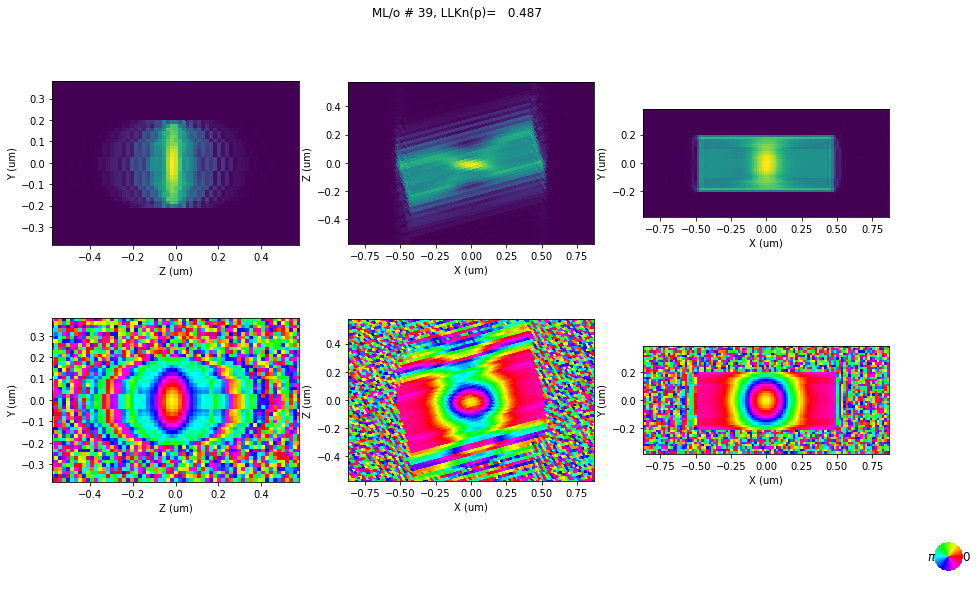

In [9]:
# Solve this
%matplotlib notebook
p = DM(calc_llk=1, show_obj_probe=10) ** 80 * p
p = AP(calc_llk=10, show_obj_probe=10) ** 40 * p
p = ML(calc_llk=1, show_obj_probe=10) ** 40 * p

p = FreePU() * P # Free me
# np.savez('/Users/favre/tmp/bragg.npz', probe3d=p._probe3d, obj=p.get_obj(), probe2d=pr.get(shift=True), x=x, y=y, z=z)